In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge




In [2]:
df_W2V = pd.read_pickle("data/dades_W2V.pkl")
df_W2V = df_W2V.iloc[:, 2:]

In [3]:
x = df_W2V.drop("Investment", axis=1)
x.columns = x.columns.astype(str)   #No se perquè, però si no ho faig em dona error
y = df_W2V["Investment"]

In [4]:
print(x.shape)
print(y.shape)

(623, 417)
(623,)


Model de regressió normal i corrent

In [5]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)
print(reg.score(train_X,train_y))
print(reg.score(test_X,test_y))

0.6161285683468387
-0.8752264208538107


Lasso

In [6]:
results = []
c = 0
for i in np.logspace(1, 3, num=40):
    m = []
    n = []
    for r in range(1,41):
        print(f"{round((c+(r-1)/40)/40*100,1)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        lasso_reg = linear_model.Lasso(alpha=i, max_iter=100, tol=0.1)
        lasso_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(lasso_reg.score(train_X, train_y))
        n.append(lasso_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])
    c=c+1

df_results_lasso = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_lasso.loc[df_results_lasso['val_score_mean'].idxmax()])
df_results_lasso.to_pickle(path="data/lasso_W2V.pkl")

#print(df_results_lasso)

alpha               170.125
train_score_mean      0.284
val_score_mean        0.162
Name: 24, dtype: float64


In [7]:
df_results_lasso = pd.read_pickle("data/lasso_W2V.pkl")
alpha = float(df_results_lasso.loc[df_results_lasso['val_score_mean'].idxmax(),"alpha"])
lasso_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
lasso_reg.fit(x, y)
y_pred = lasso_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", lasso_reg.score(x, y))
print("MSE:", mse)

R² (score): 0.2761512206976927
MSE: 427.44077457278735


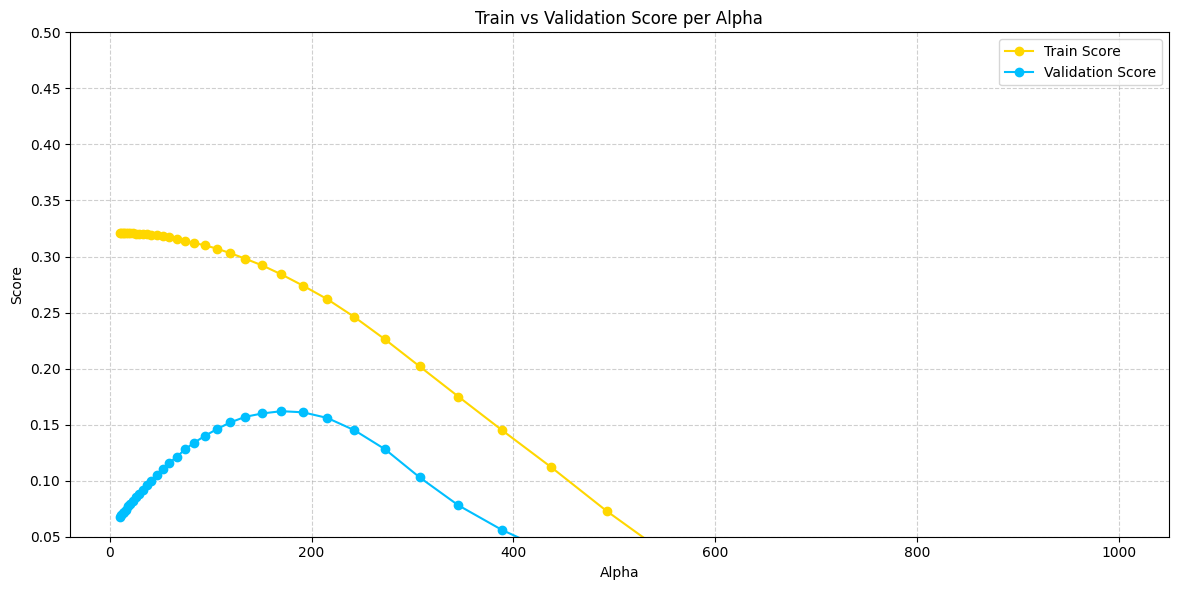

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_lasso['alpha']
train_scores = df_results_lasso['train_score_mean']
val_scores = df_results_lasso['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.5)

plt.show()


Ridge

In [9]:
results = []
c=0
for i in np.logspace(-3, 3, num=40):
    m = []
    n = []
    print(f"{c/40}%", end='\r', flush=True)
    c = c+1
    for r in range(1,41):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        ridge_reg = linear_model.Ridge(alpha=i, max_iter=100, tol=0.1)
        ridge_reg.fit(train_X, train_y)
        #print([i, ridge_reg.score(train_X, train_y), ridge_reg.score(test_X, test_y)])
        m.append(ridge_reg.score(train_X, train_y))
        n.append(ridge_reg.score(test_X, test_y))
    results.append([round(float(i), 3), round(float(np.mean(m)), 3), round(float(np.mean(n)), 3)])

df_results_ridge = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean'])
print(df_results_ridge.loc[df_results_ridge['val_score_mean'].idxmax()])
#print(df_results_ridge)
df_results_ridge.to_pickle(path="data/ridge_W2V.pkl")


alpha               119.378
train_score_mean      0.423
val_score_mean        0.112
Name: 33, dtype: float64


In [10]:
df_results_ridge = pd.read_pickle("data/ridge_W2V.pkl")
alpha = float(df_results_ridge.loc[df_results_ridge['val_score_mean'].idxmax(),"alpha"])
ridge_reg = linear_model.Ridge(alpha=alpha, max_iter=1000, tol=0.01)
ridge_reg.fit(x, y)
y_pred = ridge_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", ridge_reg.score(x, y))
print("MSE:", mse)

R² (score): 0.4085228415098362
MSE: 349.273856634576


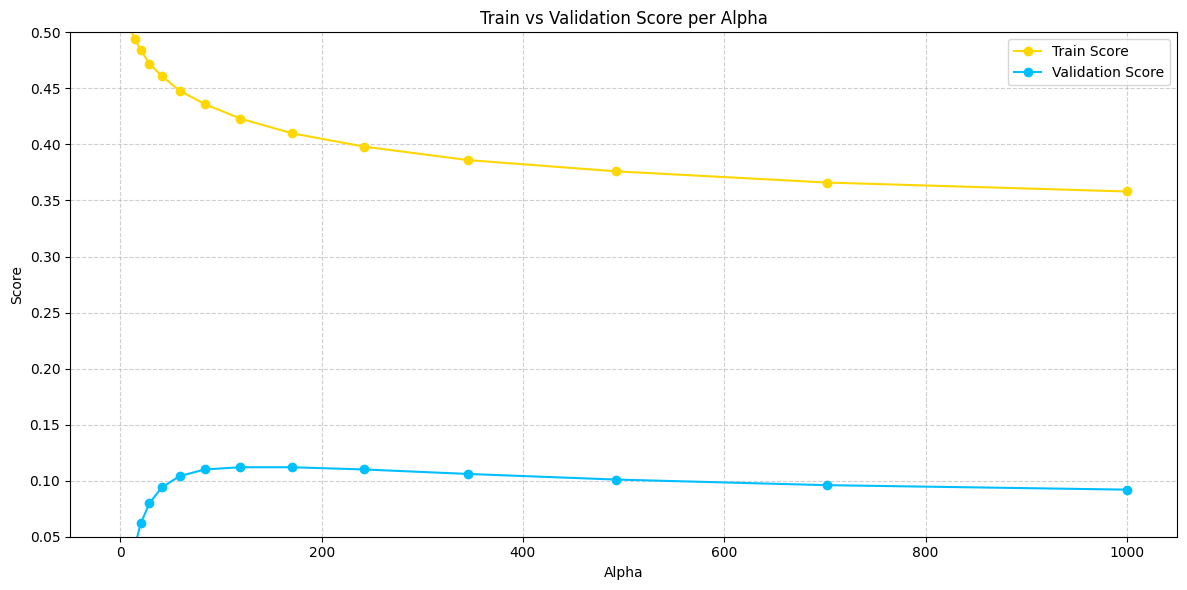

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_ridge['alpha']
train_scores = df_results_ridge['train_score_mean']
val_scores = df_results_ridge['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0.05, 0.5)

plt.show()


Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

talls = np.concatenate([np.arange(1, 101, 5)])

results_rf = []
c = 0

# Prova diferents valors de n_estimators (nombre d’arbres)
for n_estimators in talls:
    m = []
    n = []
    c += 1
    for r in range(1, 41):
        print(f"{round((c-1+(r-1)/40)*100/len(talls), 5)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_reg.fit(train_X, train_y)
        m.append(rf_reg.score(train_X, train_y))
        n.append(rf_reg.score(test_X, test_y))
    results_rf.append([n_estimators, round(np.mean(m), 3), round(np.mean(n), 3)])

df_results_rf = pd.DataFrame(results_rf, columns=['n_estimators', 'train_score_mean', 'val_score_mean'])
print(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax()])

# Desa i recarrega si cal
df_results_rf.to_pickle(path="data/rf_W2V.pkl")

n_estimators        31.000
train_score_mean     0.909
val_score_mean      -0.005
Name: 6, dtype: float64


In [13]:

df_results_rf = pd.read_pickle("data/rf_W2V.pkl")

# Entrena el model final amb el millor n_estimators
best_n = int(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax(), 'n_estimators'])
rf_reg = RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1)
rf_reg.fit(x, y)
y_pred = rf_reg.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", rf_reg.score(x, y))
print("MSE:", mse)


R² (score): 0.9056796565210231
MSE: 55.69721442852299


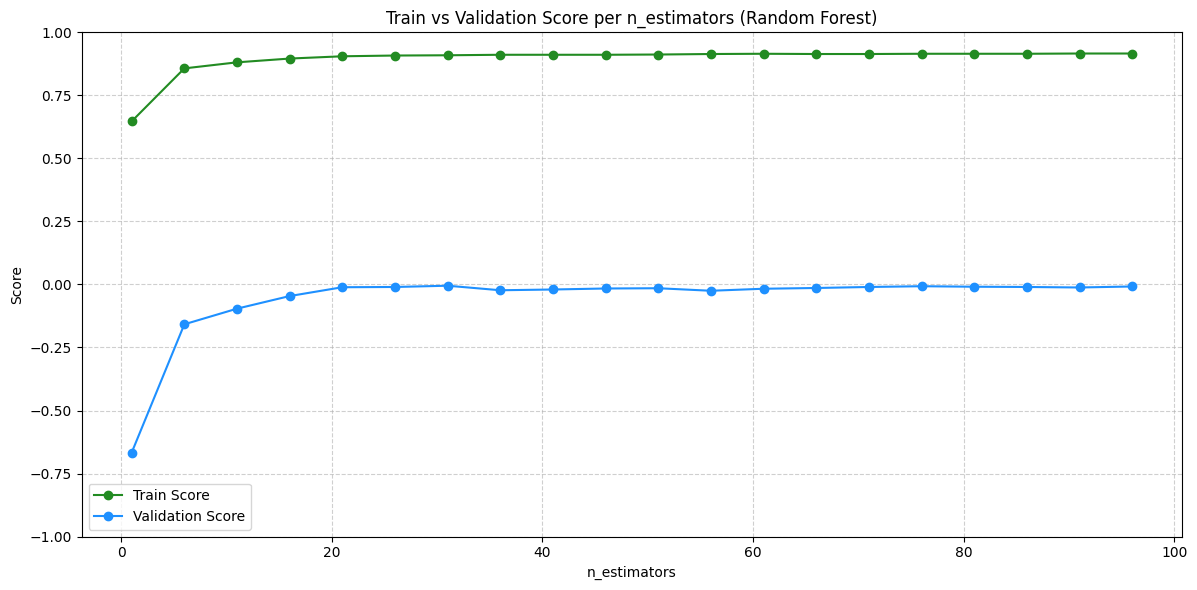

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_rf['n_estimators']
train_scores_rf = df_results_rf['train_score_mean']
val_scores_rf = df_results_rf['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-1, 1) 

plt.show()


XGBoost

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

talls = np.arange(1, 30, 1)
results = []
c = 0

for i in talls:
    train_scores = []
    test_scores = []
    test_mse = []
    
    for r in range(1, 41):
        print(f"{round(100 * (c+(r-1)/40)/len(talls), 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        model = XGBRegressor(n_estimators=int(i), max_depth=6, learning_rate=0.1, verbosity=0)
        model.fit(train_X, train_y)
        train_scores.append(model.score(train_X, train_y))
        test_scores.append(model.score(test_X, test_y))
        y_pred = model.predict(test_X)
        test_mse.append(mean_squared_error(test_y, y_pred))
    results.append([int(i), round(np.mean(train_scores), 3), round(np.mean(test_scores), 3), round(np.mean(test_mse), 3)])
    c += 1

df_results_xgb = pd.DataFrame(results, columns=['n_estimators', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax()])
df_results_xgb.to_pickle("data/xgb_W2V.pkl")


n_estimators          7.000
train_score_mean      0.608
val_score_mean        0.257
val_mse_mean        460.695
Name: 6, dtype: float64


In [5]:
df_results_xgb = pd.read_pickle("data/xgb_W2V.pkl")

best_n = int(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax(), 'n_estimators'])
model = XGBRegressor(n_estimators=best_n)
model.fit(x, y)
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", model.score(x, y))
print("MSE:", mse)

R² (score): 0.9253626559721806
MSE: 44.074183801286466


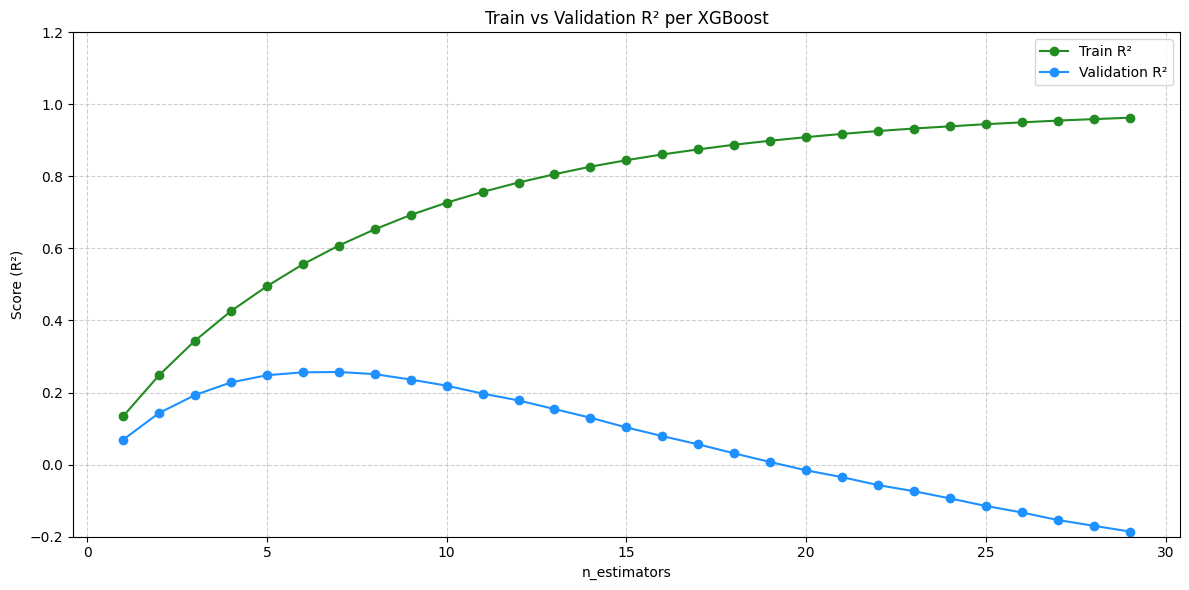

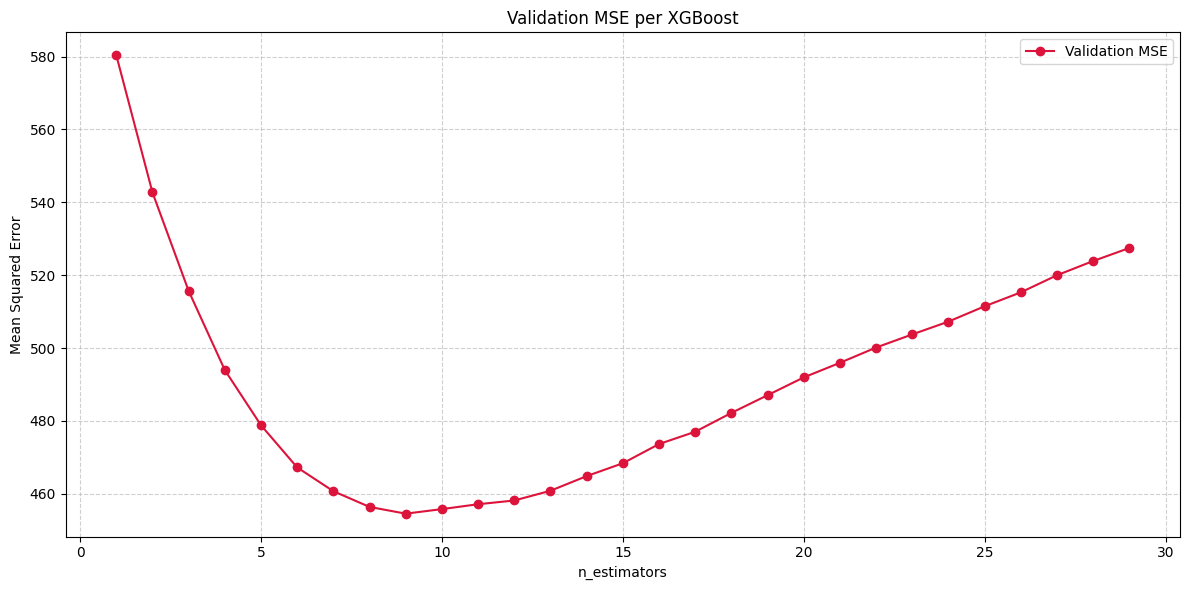

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del XGBoost
n_estimators = df_results_xgb['n_estimators']
train_scores = df_results_xgb['train_score_mean']
val_scores = df_results_xgb['val_score_mean']
val_mse = df_results_xgb['val_mse_mean']

# Gràfic 1: R² Train vs Validation
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores, marker='o', color='forestgreen', label='Train R²')
plt.plot(n_estimators, val_scores, marker='o', color='dodgerblue', label='Validation R²')
plt.xlabel('n_estimators')
plt.ylabel('Score (R²)')
plt.title('Train vs Validation R² per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(-0.2, 1.2)
plt.show()

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

SVR

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

results = []
c = 0
for i in np.logspace(-5, 0, num=20):
    train_scores = []
    val_scores = []
    
    for r in range(1, 41):  # pots fer més o menys iteracions
        print(f"{round((c+(r-1)/40)/20*100, 2)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        
        svr_model = SVR(C=i, kernel='linear', epsilon=0.1, max_iter=1000)
        svr_model.fit(train_X, train_y)
        
        train_scores.append(svr_model.score(train_X, train_y))
        val_scores.append(svr_model.score(test_X, test_y))
    c += 1
    results.append([round(i, 4), np.mean(train_scores), np.mean(val_scores)])

# Guardem els resultats
df_results_svr = pd.DataFrame(results, columns=['C', 'train_score_mean', 'val_score_mean'])
print(df_results_svr.loc[df_results_svr['val_score_mean'].idxmax()])
df_results_svr.to_pickle("data/svr_W2V.pkl")


C                   0.000200
train_score_mean    0.226765
val_score_mean      0.165124
Name: 5, dtype: float64


In [12]:
df_results_svr = pd.read_pickle("data/svr_W2V.pkl")
best_C = df_results_svr.loc[df_results_svr['val_score_mean'].idxmax(), 'C']
final_svr = SVR(C=best_C, kernel='linear', epsilon=0.1, max_iter=1000)
final_svr.fit(x, y)
y_pred = final_svr.predict(x)
mse = mean_squared_error(y, y_pred)
print("R² (score):", final_svr.score(x, y))
print("MSE:", mse)


R² (score): 0.21373806443617682
MSE: 464.2964392071447


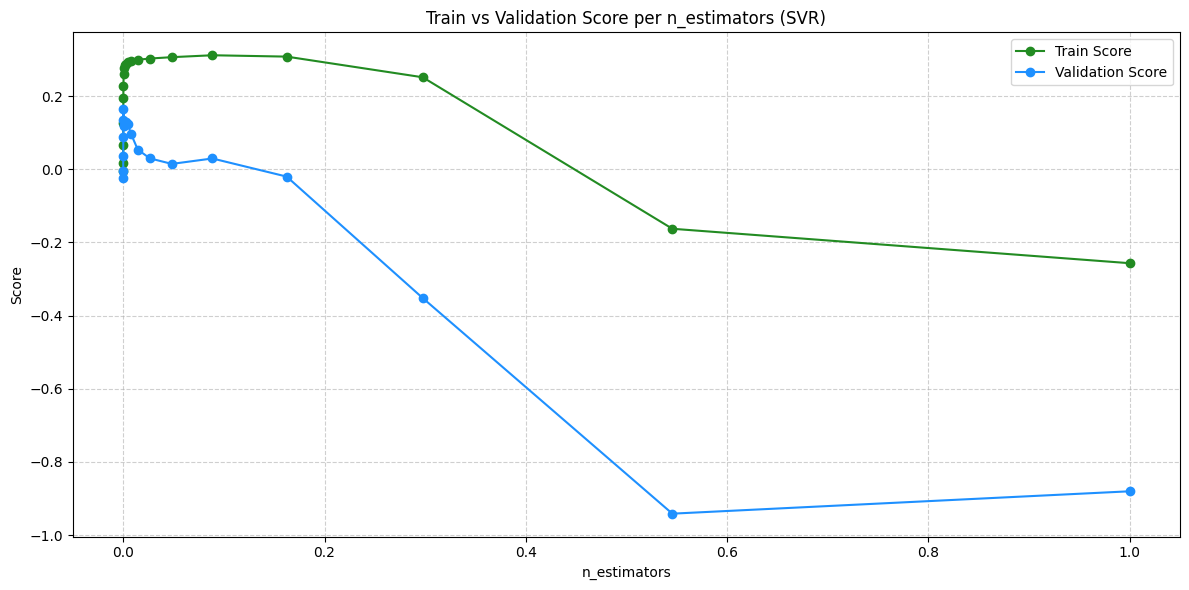

In [13]:
import matplotlib.pyplot as plt
import numpy as np

n_estimators = df_results_svr['C']
train_scores_rf = df_results_svr['train_score_mean']
val_scores_rf = df_results_svr['val_score_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (SVR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-0.3, 0.5)

plt.show()
